# Imports

In [18]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt

import os

import openpyxl
import math

from os import listdir
from os.path import isfile, join

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, accuracy_score
import seaborn as sb



dataDir = './archive/imagesMainWork'
anotation_path = './archive/annotations'

# Run to generate the initial file 
## Filtered dataset information processed - 85%

In [22]:
# import xlsxwriter module
import xlsxwriter
import xml.dom.minidom


from os import listdir, remove
from os.path import isfile, join
onlyfiles = [".".join(f.split(".")[:-1]) for f in listdir(dataDir) if isfile(join(dataDir, f))]
 
workbook = xlsxwriter.Workbook('RoadSigns.xlsx')
worksheet = workbook.add_worksheet()

worksheet.write('A1', 'File Name')
worksheet.write('B1', 'Type of Sign')
worksheet.write('C1', 'Type of Sign Detected')
# Start from the first cell.
# Rows and columns are zero indexed.
row = 1
column = 0

 
# iterating through content list
for item in onlyfiles :
    typeOfSign = "";
    doc = xml.dom.minidom.parse(os.path.join(anotation_path,item + ".xml"));
    
    signsNames = doc.getElementsByTagName("name")
    
    # if more than one annotation, erase image
    if len(signsNames) > 1:
        os.remove('./archive/imagesClean/' + item + '.png')   #FIXME: CHECK PATH FOR DELETION (with ImagesClean it won't delete anything)
        continue

    for sign in signsNames:
        if sign.childNodes[0].nodeValue == "stop":
            typeOfSign = "stop";
        elif sign.childNodes[0].nodeValue == "crosswalk":
            typeOfSign = "crosswalk";
        elif sign.childNodes[0].nodeValue == "speedlimit":
            typeOfSign = "speedlimit";
    
    # write operation perform
    if typeOfSign == "speedlimit":
        worksheet.write(row, column, item)
        worksheet.write(row, 1, typeOfSign)
        # incrementing the value of row by one
        # with each iterations.
    
    elif typeOfSign == "stop":
        worksheet.write(row, column, item)
        worksheet.write(row, 1, typeOfSign)
        
    else:
        worksheet.write(row, column, item)
        worksheet.write(row, 1, "other")
 
    # incrementing the value of row by one
    # with each iterations.
    row += 1
     
workbook.close()

# Function to Detect Red Circles

In [5]:
# CLAHE

def clahe(testImg):
    testImg = cv2.cvtColor(testImg, cv2.COLOR_RGB2HSV)

    h, s, v = testImg[:,:,0], testImg[:,:,1], testImg[:,:,2]

    clahe = cv2.createCLAHE(clipLimit = 2.0, tileGridSize = (8, 8))

    v = clahe.apply(v)

    testImg = np.dstack((h, s, v))

    testImg = cv2.cvtColor(testImg, cv2.COLOR_HSV2RGB)
    
    return testImg

# REMOVE SHADOWS

def removeShadows(testImg):
    
    rgb_planes = cv2.split(testImg)
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        result_norm_planes.append(norm_img)

    testImg = cv2.merge(result_norm_planes)
    
    return testImg

#

def redMask(testImg):
    
    testImgRed = testImg.copy()
    testImg = cv2.cvtColor(testImg, cv2.COLOR_RGB2HSV)

    # lower mask (0-10)
    lower_red = np.array([0,50,50])
    upper_red = np.array([10,255,255])
    mask0 = cv2.inRange(testImg, lower_red, upper_red)

    # upper mask (170-180)
    lower_red = np.array([170,50,50])
    upper_red = np.array([180,255,255])
    mask1 = cv2.inRange(testImg, lower_red, upper_red)

    # join my masks
    mask = mask0+mask1

    
    testImgRed = cv2.cvtColor(testImgRed, cv2.COLOR_RGB2HSV)
    
    testImgRed[np.where(mask==0)] = 0
    
    testImgRed = cv2.cvtColor(testImgRed, cv2.COLOR_HSV2RGB)
    
    testImg = cv2.cvtColor(testImg, cv2.COLOR_HSV2RGB)
    
    return testImgRed


# CLOSING

def closing(testImgRed):
    testImgRed = cv2.GaussianBlur(testImgRed, (11,11), 3)
    testImgGray = cv2.cvtColor(testImgRed, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
    testImgGray = cv2.morphologyEx(testImgGray, cv2.MORPH_CLOSE, kernel)

    return testImgGray



def findCircles(testImgRed):
    # Use the Hough transform to detect circles in the image
    circles = cv2.HoughCircles(testImgRed, cv2.HOUGH_GRADIENT, 1, testImgRed.shape[0] / 8, param1=50, param2=45, minRadius=0, maxRadius=0)
    # If we have extracted a circle, draw an outline
    # We only need to detect one circle here, since there will only be one reference object
    return circles

def detectCircles(ogImage, draw):
    finalImg = ogImg.copy()
    testImg = ogImg.copy()
            
    for i in range(3):
        testImg = ogImg.copy()
        if i == 0:
            noShadows = removeShadows(testImg)
            redOnly = redMask(noShadows)
            grayClosing = closing(redOnly)
            circles = findCircles(grayClosing)        
        if i == 1:
            claheImg = clahe(testImg)
            redOnly = redMask(claheImg)
            grayClosing = closing(redOnly)
            circles = findCircles(grayClosing)
        if i == 2:
            redOnly = redMask(testImg)
            grayClosing = closing(redOnly)
            circles = findCircles(grayClosing)
        if circles is not None:
            if draw:
                circles = np.uint16(np.around(circles))
                for i in circles[0,:]:
                    # draw the outer circle
                    cv2.circle(finalImg,(i[0],i[1]),i[2],(39, 255, 0),2)
                    # draw the center of the circle
                    cv2.circle(finalImg,(i[0],i[1]),2,(0,0,255),3)
                    # write text
                    cv2.putText(img=finalImg, text='Red Circle', org=(i[0]-45,i[1]+i[2]+15), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5, color=(39, 255, 0),thickness=2)
                finalImg = cv2.cvtColor(finalImg, cv2.COLOR_RGB2BGR)
                cv2.imshow('Circles Detected', finalImg)
                cv2.waitKey(0)
                cv2.destroyAllWindows()
            return circles.shape[1]
    return 0
    
    


# Function to Detect Red Circles - Example

In [6]:
ogImg = cv2.imread(os.path.join(dataDir, "road119.png"))
    
ogImg = cv2.cvtColor(ogImg, cv2.COLOR_BGR2RGB)
    
nrCircles = detectCircles(ogImg, True)

# Function to detect blue squares - Pre Process

In [7]:
def smooth(img): 

    # remove noise
    # Using a Median Filter
    img_smoothed = cv2.medianBlur(img, 5)

    return img_smoothed
    # return img

def contrastAdjust(img):

    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    h, s, v = img[:, :, 0], img[:, :, 1], img[:, :, 2]

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

    v = clahe.apply(v)

    img = np.dstack((h, s, v))

    img_clean = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
    
    return img_clean

def removeShadowsBlue(img):
    rgb_planes = cv2.split(img)
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7, 7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 41)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(
            diff_img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        result_norm_planes.append(norm_img)

    img_clean = cv2.merge(result_norm_planes)

    return img_clean


# Function to detect blue squares - Angles

In [8]:
# TODO: CHANGE THIS

def calcAngles(cnt_img, corners):
    angles = []
    
    # Calculate euclidean distance between each corner
    dist1 = int(math.sqrt(math.pow(corners[0] - corners[2], 2) +
                       math.pow(corners[1] - corners[3], 2)))
    dist2 = int(math.sqrt(math.pow(corners[2] - corners[4], 2) +
                       math.pow(corners[3] - corners[5], 2)))
    dist3 = int(math.sqrt(math.pow(corners[4] - corners[6], 2) +
                   math.pow(corners[5] - corners[7], 2)))
    dist4 = int(math.sqrt(math.pow(corners[6] - corners[0], 2) +
                   math.pow(corners[7] - corners[1], 2)))

    
    max_radius = min([dist1, dist2, dist3, dist4])

    for i in range(len(corners[:-1]), 2):
        blank_img = np.zeros((len(cnt_img), len(cnt_img[0])), np.uint8)
        cv2.circle(blank_img, (corners[i], corners[i + 1]),
                  max_radius // 2, (255, 255, 255))
        intersect_img = cv2.bitwise_and(cnt_img, blank_img)

        intersect_pts = np.where(intersect_img > 1)

        if(len(intersect_pts[0]) < 2 or len(intersect_pts[1]) < 2):
            angles.append(0)
            continue

        vector1 = (intersect_pts[1][0] - corners[i],
                   intersect_pts[0][0] - corners[i + 1])
        vector2 = (intersect_pts[1][1] - corners[i],
                   intersect_pts[0][1] - corners[i + 1])

        scalar_p = vector1[0] * vector2[0] + vector1[1] * vector2[1]
        norm1 = math.sqrt(math.pow(vector1[0], 2) + math.pow(vector1[1], 2))
        norm2 = math.sqrt(math.pow(vector2[0], 2) + math.pow(vector2[1], 2))

        angle = math.acos(scalar_p / (norm1 * norm2)) * 180 / math.pi
        angles.append(angle)

    return angles

# Function to detect blue squares - Feature Recognition

In [9]:
def featureRecognition(img): 

    # Segmentation to recognize colour blue
    # Converts images from BGR to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Bounds adjusted to identify shades of blue correspondent to traffic signs
    lower_blue = np.array([100, 100, 80])
    upper_blue = np.array([150, 255, 255])

    # Here we are defining range of bluecolor in HSV
    # This creates a mask of blue coloured
    # objects found in the frame.
    mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # The bitwise and of the frame and mask is done so
    # that only the blue coloured objects are highlighted
    # and stored in res
    res = cv2.bitwise_and(img, img, mask=mask)


    # Post-Segmentation smoothing 
    # res = smooth(res)  


    # Contours on Resulting Image
    gray_img = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
    # Apply Canny
    canny = cv2.Canny(gray_img, 130, 255)

    # Find Contours
    # RETR_CCOMP: retrieves all of the contours and organizes them into a two-level hierarchy. At the top level, there are external boundaries of the components. 
    # At the second level, there are boundaries of the holes. If there is another contour inside a hole of a connected component, it is still put at the top level.
    cnts = cv2.findContours(
        canny, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]


    for c in range(len(cnts)):
        cnt_len = cv2.arcLength(cnts[c], True)

        # Small contours will appear in green; can be commented and code will still work
        if(cnt_len <= 70):
            cv2.drawContours(img, [cnts[c]], 0, (0, 255, 0), 3)
            continue 

        # Recognize most approximate CLOSED Poly-shape to contour to draw
        approx_poly = cv2.approxPolyDP(
            cnts[c], 0.03 * cv2.arcLength(cnts[c], True), True)

        # Rectangle Recognition through Distance and Angle Analysis
        ravel = approx_poly.ravel()
        n_sides = len(approx_poly)
        angle_cdt = False 

        # Nº of Sides is 4 = Square/Rectangle
        if(n_sides == 4): 
            angle_cdt = True 

            cnt_img = np.zeros((len(img), len(img[0])), np.uint8)
            angles = calcAngles(cv2.drawContours(cnt_img, [approx_poly], -1, (255), 1), ravel)

            for a in angles:
                if(abs(a - 90) > 10):
                    angle_cdt=False
                    break
            
        if(angle_cdt):
            img = cv2.drawContours(img, [approx_poly], -1, (0, 230, 255), 3)

In [10]:
#SIFT & FLANN & RANSAC
def featureDetectionAndMatching(img, train_list):

    MIN_MATCH_COUNT = 5
    count = 0
    for img_path in train_list:

        img_train = cv2.imread(img_path)

        # Initiate SIFT detector
        sift = cv2.SIFT_create()

        
        # find the keypoints & compute descriptors
        kp, des = sift.detectAndCompute(img_train, None)
        kp2, des2 = sift.detectAndCompute(img, None)


        # create FLANN feature matcher
        FLANN_INDEX_KDTREE = 1

        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des, des2, k=2)

        # store all the good matches as per Lowe's ratio test.
        good = []
        for m, n in matches:
            if m.distance < 0.7*n.distance:
                good.append(m)

        if len(good) >= MIN_MATCH_COUNT:
            src_pts = np.float32([kp[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
            matchesMask = mask.ravel().tolist()
            h, w = img_train.shape[:2]
            pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]
                            ).reshape(-1, 1, 2)
            if not M is None:
                dst = cv2.perspectiveTransform(pts, M)
                img = cv2.polylines(img, [np.int32(dst)], True, 255, 3, cv2.LINE_AA)
            else:   
                continue
        else:
            matchesMask = None
            continue

        count+=1

    return count

# Function to Detect Stop Signs

In [11]:
def differenceBtwPointsTooSmall(array,size):
    maxLimit = size-1
    pointsDistanceSum = 0
    for i in range(size):
        if i != maxLimit:
            pointsDistanceSum += math.dist(array[i][0],array[i+1][0])
        else:
            pointsDistanceSum += math.dist(array[i][0],array[0][0])
    
    averageValue = pointsDistanceSum / size
    
    if averageValue < 5:
        return True
    
    return False

def redMasks(ogImg):
    #blurring and smoothin
    img1= ogImg.copy()

    hsv = cv2.cvtColor(img1,cv2.COLOR_BGR2HSV)

    #lower red
    lower_red = np.array([0,50,50])
    upper_red = np.array([10,255,255])


    #upper red
    lower_red2 = np.array([170,50,50])
    upper_red2 = np.array([180,255,255])

    mask = cv2.inRange(hsv, lower_red, upper_red)
    res = cv2.bitwise_and(img1,img1, mask= mask)


    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    res2 = cv2.bitwise_and(img1,img1, mask= mask2)

    img3 = res+res2
    img4 = cv2.add(res,res2)
    img5 = cv2.addWeighted(res,0.5,res2,0.5,0)


    kernel = np.ones((15,15),np.float32)/225
    smoothed = cv2.filter2D(res,-1,kernel)
    smoothed2 = cv2.filter2D(img3,-1,kernel)

def findStops(image):
    ret,thresh1 = cv2.threshold(image[:,:,0], 0, 255,cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    thresh1 = cv2.bitwise_not(thresh1)

#     cv2.imshow('thresh', thresh1)       
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()
    contours, hierarchy = cv2.findContours(thresh1, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    stops = []
    for cnt in contours:
        approx = cv2.approxPolyDP(cnt,0.011*cv2.arcLength(cnt,True),True)
        if len(approx)==8 and not differenceBtwPointsTooSmall(approx,8):
            stops.append(cnt)
    
    return stops;

def detectStops(ogImg, draw):
    finalImg = ogImg.copy()
    testImg = ogImg.copy()
            
    for i in range(3):
        testImg = ogImg.copy()
        if i == 0:
            redOnly = redMask(testImg)
            stops = findStops(redOnly) 
        if i == 1:
            noShadows = removeShadows(testImg)
            redOnly = redMask(testImg)
            stops = findStops(redOnly)    
#         if i == 2:
#             claheImg = clahe(testImg)
#             redOnly = redMask(claheImg)
#             grayClosing = closing(redOnly)
#             stops = findCircles(grayClosing)
#         if i == 3:
#             redOnly = redMask(testImg)
#             grayClosing = closing(redOnly)
#             stops = findCircles(grayClosing)
        if len(stops) > 0:
            imageToDraw = finalImg.copy
            if draw:
                newImage = cv2.cvtColor(finalImg, cv2.COLOR_RGB2BGR)
                for cnt in stops:
                    cv2.drawContours(newImage, [cnt], 0, (0, 255, 0), 6)
                    
                cv2.imshow('Stops Detected', newImage)
                cv2.waitKey(0)
                cv2.destroyAllWindows()
            
            return len(stops)
    return 0

# Function to Detect Stops Signs - Example

In [12]:
originalImg = cv2.imread(os.path.join(dataDir, "road97.png"))
    
originalImg = cv2.cvtColor(originalImg, cv2.COLOR_BGR2RGB)

nrStops = detectStops(originalImg, True)

# Loop to analize the entire data set (download from kaggle)

In [13]:
onlyfiles = [f for f in listdir(dataDir) if isfile(join(dataDir, f))]
 
workbook = openpyxl.load_workbook("RoadSigns.xlsx")
 
sheet = workbook.active

row_number = 2

 
# iterating through content list
for item in onlyfiles :
    
    ogImg = cv2.imread(os.path.join(dataDir, item))
    
    ogImg = cv2.cvtColor(ogImg, cv2.COLOR_BGR2RGB)
    
    ogImgCircles = ogImg.copy()
    ogImgStops = ogImg.copy()
    
    nrCircles = detectCircles(ogImgCircles, False)
    
    nrStops = detectStops(ogImgStops, False)
    
    if nrStops > 0: 
        sheet.cell(row = row_number, column = 3, value = "stop")
    elif nrCircles > 0:
        sheet.cell(row = row_number, column = 3, value = "speedlimit")
    else: 
        sheet.cell(row = row_number, column = 3, value = "other")
   
    row_number += 1

workbook.save("RoadSigns.xlsx")

# Evaluate the Results

Report:
              precision    recall  f1-score   support

       other       0.27      0.65      0.38        75
  speedlimit       0.90      0.66      0.76       399
        stop       0.63      0.66      0.65        61

    accuracy                           0.66       535
   macro avg       0.60      0.66      0.60       535
weighted avg       0.78      0.66      0.70       535


AUC Score:
{'speedlimit': 0.7229562877782691, 'stop': 0.8036072490834889, 'other': 0.6842753623188406}



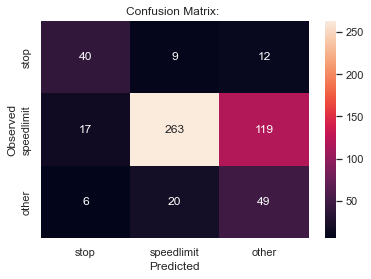

In [20]:
actual = sheet['B']
detected = sheet['C']

def mapping(cell):
    return cell.value

actual = list(map(mapping, actual[1:]))
detected = list(map(mapping, detected[1:]))


def roc_auc_score_multiclass(actual_class, detected_class, average = "macro"):
    
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in detected_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict
    
def evaluation(actual, detected):
    report = classification_report(
        actual, detected, output_dict=True, zero_division=0)
    print(f"Report:\n{classification_report(actual, detected,zero_division= 0)}\n")
    print(f"AUC Score:\n{roc_auc_score_multiclass(actual, detected)}\n")
    sb.set(font_scale=1.0)
    labels = ["stop", "speedlimit", "other"]
    i = 0
    cm = confusion_matrix(actual, detected, labels=["stop", "speedlimit", "other"])
    ax = plt.subplot()
    sb.heatmap(cm, annot=True, ax=ax, fmt="g")

    ax.set_xlabel('Predicted')
    ax.set_ylabel('Observed')
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    ax.set_title("Confusion Matrix: ")
    plt.show()
    i += 1

evaluation(actual, detected)
